In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import config
import utility.df
import utility.iolib
import utility.plotlib
from utility.feature import Feature

#env = sys.argv[1] if len(sys.argv) > 2 else "dev"

In [2]:
# Setup configuration
cfg = config.ResearchConfig
time_format = cfg.CSV_TIME_FORMAT
date_format = cfg.CSV_DATE_FORMAT
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)

# Retrieve data
df_subspt, df_lesson, df_incomp, df_crclum, df_pupils = utility.iolib.retrieve_data(cfg)
print("Complete loading data for subscription and lesson history!")

Complete loading data for subscription and lesson history!


In [3]:
# Filter data
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)
first_date_impFromData = df_subspt.subscription_start_date.min()

pupils_toBeRemoved = utility.df.filter_subspt_data(
    df_subspt, first_date_impFromData, cutoff_date, remove_annual_subspt=False)
df_lesson1 = df_lesson[~df_lesson['pupilId'].isin(pupils_toBeRemoved)]
df_incomp1 = df_incomp[~df_incomp['pupilId'].isin(pupils_toBeRemoved)]
df_subspt1 = df_subspt[~df_subspt['pupilId'].isin(pupils_toBeRemoved)]

df_subspt1 = utility.df.compute_customer_month(df_subspt1, cfg)

By the cutoff date 2018-04-20, there are 1234 active subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to know the lifetime of their subscriptions. 

In the first month of dataset starting from 2014-01-01, there are 154 renewal or new subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to show if they renewed or newly joined. 

In summary, there are 1380/5685 subscribers being removed from the dataset in the analysis. 

Calculate customer month in the subscription table.


100%|██████████| 4305/4305 [00:05<00:00, 813.82it/s] 


# Features

In [4]:
# Construct dates frame
df_datesFrame = utility.df.construct_dates_frame(df_subspt1, df_lesson1, df_incomp1, cfg)

# Initialise feature obj
ftr = Feature(df_datesFrame)

ftr.add_usageTime(df_lesson1, df_incomp1)
ftr.add_progressions(df_lesson1)
ftr.add_age(df_pupils)

Construct data-driven dates frame.
The dates frame has already been assigned customer month and saved in a file. The file has been loaded!
+ Add feature: usage time.
+ Add feature: progressions.
+ Add feature: pupils' age.


In [7]:
ftr.df_features_

count_complete  count_incomplete  customer_month  \
pupilId date                                                           
655886  2014-04-18             2.0               0.0             0.0   
        2014-04-19             1.0               0.0             0.0   
        2014-04-20             2.0               0.0             0.0   
        2014-04-21             3.0               0.0             0.0   
        2014-05-18             5.0               0.0             0.0   
        2014-10-21             9.0               0.0             1.0   
        2014-10-22             3.0               0.0             1.0   
        2014-12-23             9.0               0.0             3.0   
        2015-03-06             3.0               0.0             5.0   
        2015-05-17             7.0               0.0             7.0   
658323  2013-12-12             1.0               0.0             0.0   
        2013-12-27             2.0               0.0             0.0   
        2014-02-23             1.0               0.0             0.0   
        2016-03-10            15.0               0.0             1.0   
        2016-03-11             2.0               0.0             1.0   
        2016-03-13            27.0               0.0             1.0   
        2016-03-14             2.0               0.0             1.0   
        2016-03-16             5.0               0.0             1.0   
        2016-03-17             5.0               0.0             1.0   
        2016-03-19             5.0               0.0             1.0   
        2016-03-21             6.0               0.0             1.0   
        2016-03-22            11.0               0.0             1.0   
        2016-03-23             8.0               0.0             1.0   
        2016-03-25             4.0               0.0             1.0   
        2016-03-29            12.0               0.0             1.0   
        2016-04-12            11.0               0.0             2.0   
        2016-04-13            14.0               0.0             2.0   
        2016-04-16             8.0               0.0             2.0   
        2016-04-19             6.0               0.0             2.0   
        2016-04-20             6.0               0.0             2.0   
...                            ...               ...             ...   
1280885 2018-02-14             0.0               1.0             1.0   
        2018-02-21             0.0               1.0             1.0   
        2018-02-27             0.0               1.0             1.0   
        2018-03-04             0.0               5.0             1.0   
        2018-03-10             0.0               1.0             1.0   
1281418 2018-02-28             0.0               1.0             1.0   
        2018-03-17             0.0               2.0             1.0   
1284479 2018-02-25             0.0               2.0             1.0   
        2018-02-26             0.0               2.0             1.0   
        2018-03-10             0.0               1.0             1.0   
1288697 2018-03-13             0.0               1.0             0.0   
        2018-03-14             0.0               1.0             0.0   
        2018-03-18             0.0               1.0             1.0   
        2018-03-20             0.0               1.0             1.0   
        2018-03-22             0.0               1.0             1.0   
        2018-03-29             0.0               1.0             1.0   
        2018-03-30             0.0               1.0             1.0   
        2018-04-02             0.0               1.0             1.0   
        2018-04-03             0.0               1.0             1.0   
        2018-04-06             0.0               2.0             1.0   
        2018-04-09             0.0               3.0             1.0   
1288973 2018-03-13             0.0               1.0             1.0   
        2018-03-16             0.0               1.0        

# Analysis

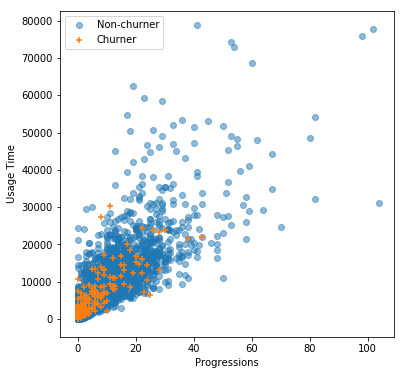

In [9]:
study_month = 2

df_features = ftr.df_features_
df_features['time_taken'] = df_features.time_taken_complete + df_features.time_taken_incomplete

df_features1 = df_features[df_features['customer_month']==study_month]

progress = df_features1.groupby(level=0)['progressions_delta'].sum()
usage = df_features1.groupby(level=0)['time_taken'].sum()

pupils_nextMonth = df_subspt1[df_subspt1['customer_month']==(study_month+1)]['pupilId'].unique()
pupils_nextAnnual = df_subspt1[df_subspt1['customer_month']==(study_month+12)]['pupilId'].unique()
pupils_nextMonthRenew = np.union1d(pupils_nextMonth, pupils_nextAnnual)

pupils_thisMonth = df_subspt1[df_subspt1['customer_month']==study_month]['pupilId'].unique()
pupils_nextMonthCancel = np.setdiff1d(pupils_thisMonth, pupils_nextMonthRenew)

df_agg = pd.DataFrame({'progress': progress, 'usage': usage})

df_agg['next_month_cancel'] = 0
df_agg.loc[df_agg.index.isin(pupils_nextMonthCancel), 'next_month_cancel'] = 1

fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(111)

ax.scatter(df_agg[df_agg.next_month_cancel==0].progress, df_agg[df_agg.next_month_cancel==0].usage, alpha=0.5, label='Non-churner')
ax.scatter(df_agg[df_agg.next_month_cancel==1].progress, df_agg[df_agg.next_month_cancel==1].usage, marker='+', label='Churner')
ax.set_xlabel('Progressions')
ax.set_ylabel('Usage Time')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.legend()

In [12]:
from sklearn import linear_model

C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


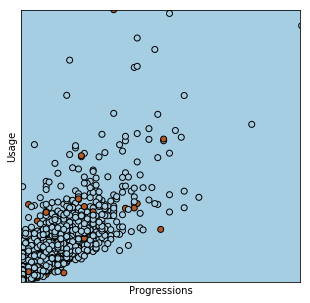

In [13]:
logreg = linear_model.LogisticRegression(C=1)
X = df_agg[['progress', 'usage']]
y = df_agg['next_month_cancel']

logreg.fit(X,y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X.iloc[:, 0].min() - .5, X.iloc[:, 0].max() + .5
y_min, y_max = X.iloc[:, 1].min() - .5, X.iloc[:, 1].max() + .5

xx, yy = np.meshgrid(np.arange(x_min, x_max, 1), np.arange(y_min, y_max, 100))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(5, 5))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Progressions')
plt.ylabel('Usage')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

In [14]:
import seaborn as sns 

C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


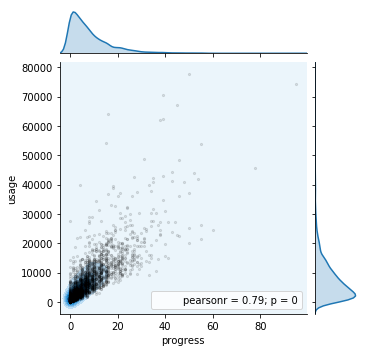

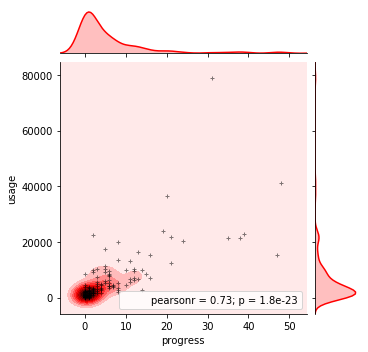

In [23]:
churner = df_agg[df_agg['next_month_cancel']==1]
nonchurner = df_agg[df_agg['next_month_cancel']==0]

g1 = sns.jointplot(x='progress', y='usage', data=nonchurner[['progress', 'usage']], kind='kde', size=5)
g1.plot_joint(plt.scatter, c="k", s=5, linewidth=1, marker="o", alpha=0.1)

g2 = sns.jointplot(x='progress', y='usage', data=churner[['progress', 'usage']], kind='kde', color='r', size=5)
g2.plot_joint(plt.scatter, c="k", s=10, linewidth=1, marker="+", alpha=0.5)